In [36]:

#from plotting.plotThesis import plot_grid_cell_modules, plot_3D_sheets
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc

# Grid Cell model is based on Edvardsen 2015. Please refer to the thesis or the paper for detailed explanations


def rec_d(d):
    """Recurrent connectivity profile used for calculating connection weight between neurons"""
    lam = 15  # determines periodicity of pattern (lambda ~ #neurons between)
    beta = 3 / (lam ** 2)
    gamma = 1.05 * beta

    weight = np.exp(-gamma * (d ** 2)) - np.exp(-beta * (d ** 2))
    return weight


# Computes distance between
def compute_ds(x1, x2):
    """Calculates distance in along one axis between x1 and x2
    x1: vector of x coordinates (eg. [0, 0, 0, 1, 1, 1, 2, 2, 2]) of size n^2
    x2: vector of other x coordinates (eg. [1, 1, 1, 2, 1, 0, 3, 1, 2]) of size n^2
    returns dx from each neuron to each neuron, matrix of size n^2 x n^2
    """
    n = int(np.sqrt(len(x1)))  # size of grid cell sheet (width and height)
    x1 = np.tile(x1, (n**2, 1))  # tile vector to fit size n^2 x n^2
    x2 = np.transpose(np.tile(x2, (n**2, 1)))  # tile vector to fit size n^2 x n^2, but transpose
    dx1 = np.abs(x2 - x1)  # calculate distance from each neuron to each neuron
    dx2 = n - dx1  # as edges of grid cell sheet are connected dx < n -> calculate other way
    dx = np.min([dx1, dx2], axis=0)  # choose shortest path (left or right)
    return dx  # return matrix of size n^2 x n^2, representing shortest distance along 1 axis


def compute_gm(m, M, gmin, gmax=None):
    """Calculates velocity gain factor g_m for all modules according to formula in thesis"""

    if gmax is None:
        # If only 1 boundary is provided, we let the gain factor increase linearly (Edvardsen 2017)
        gm = gmin * 1.5 ** m
    else:
        # Otherwise we make sure the gain factors are properly spaced between the boundaries (Edvardsen 2015)
        if M != 1:
            R = np.power(gmax / gmin, 1 / (M - 1))
        else:
            R = 1
        gm = gmin * np.power(R, m)

    return gm


def implicit_euler(s0, w, b, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    #print(w.shape)
    f = np.maximum(0, np.tensordot(s0, w, axes=1) + b)
    s = (s0 + f * dt / tau) / (1 + dt / tau)
    return s


# Not used, but defined grid cell spiking equation to be solved with built in numeric solver
def ds_dt(t, s, w, b, tau):
    f = np.maximum(0, np.tensordot(s, w, axes=1) + b)
    return (f - s) / tau


class GridCellModule:
    """One GridCellModule holds the information of a sheet of n x n neurons"""
    def __init__(self, n, gm, dt, data=None):

        self.n = n  # Grid Cell sheet size (height and width)
        self.gm = gm  # velocity gain factor

        array_length = n**2

        # connection weight matrix from each to each neuron
        self.w = np.random.random_sample((array_length, array_length))

        # self.h = np.random.random_sample((array_length, 2))
        self.s = np.random.rand(array_length) * 10**-4  # firing vector of size (n^2 x 1); random firing at beginning
        self.t = self.s  # target grid cell firing (of goal or home-base)
        self.s_virtual = self.s  # used for linear lookahead to preplay trajectories, without actually moving
        self.dt = dt  # time step size

        self.s_video_array = []

        # If we are not loading grid cell data we have to calculate grid cell sheet weights
        if data is None:
            # Refer to thesis for concept of grid cell sheet and how weights are computed

            headings = [[-1, 0], [0, 1], [0, -1], [1, 0]]  # [W, N, S, E]

            grid = np.indices((n, n))  # grid function to create x and y vectors
            x = np.concatenate(grid[1])  # x vector of form eg. [0, 0, 0, 1, 1, 1, 2, 2, 2]
            y = np.concatenate(grid[0])  # y vector of form eg. [0, 1, 2, 0, 1, 2, 0, 1, 2]
            index = 2 * np.mod(y, 2) + np.mod(x, 2)  # refer to thesis for explanation of formula
            index.astype(int)
            self.h = np.take(headings, index, axis=0)  # pick preferred heading direction for each neuron

            x_tuned = np.subtract(x, self.h[:, 0])  # tune x vector according to preferred heading direction
            y_tuned = np.subtract(y, self.h[:, 1])  # tune y vector according to preferred heading direction

            dx = compute_ds(x_tuned, x)  # compute shortest x distance between each pair of neurons (i - e_i, j)
            dy = compute_ds(y_tuned, y)  # compute shortest y distance between each pair of neurons (i - e_i, j)
            d = np.linalg.norm([dx, dy], axis=0)  # compute shortest overall distance between each pair of neurons
            self.w = rec_d(d)  # apply recurrent connectivity profile to get weights
        else:
            self.w = data["w"]
            self.h = data["h"]

    def update_s(self, v, virtual=False, dt_alternative=None):
        """Updates grid cell spiking from one to next time step"""

        tau = 1e-1  # defined by model
        alpha = 0.10315  # defined by model

        g = self.gm

        s0 = self.s_virtual if virtual else self.s  # virtual or actual mode
        dt = self.dt if dt_alternative is None else dt_alternative  # determine wanted time step size

        b = 1 + g * alpha * np.tensordot(self.h, v, axes=1)  # calculate b according to formula

        s = self.s
        if dt_alternative is None:
            # apply implicit euler once to update spiking
            s = implicit_euler(s0, self.w, b, tau, dt)
        else:
            # Alternative approach to use built in solver to calculate bigger time steps at once, large computation time
            # Because Implicit euler is unstable for large dt
            # sol = solve_ivp(ds_dt, (0, dt_alternative), s0, t_eval=[dt_alternative], args=(self.w, b, tau))
            # s = sol.y[:, 0]

            # It is faster to just apply the implicit euler several times until targeted time step is reached
            for n in range(int(dt_alternative/self.dt)):
                s0 = implicit_euler(s0, self.w, b, tau, self.dt)
            s = s0

        if virtual:
            self.s_virtual = s  # updates spiking value
            self.s_video_array.append(self.s_virtual)  # save for lookahead video
        else:
            s = implicit_euler(s0, self.w, b, tau, dt)  # this step might actually not be necessary, pls investigate
            self.s = s  # updates spiking value


class GridCellNetwork:
    """GridCellNetwork holds all Grid Cell Modules"""
    def __init__(self, n, M, dt, gmin, gmax=None, from_data=False):

        self.gc_modules = []  # array holding objects GridCellModule
        self.dt = dt

        if not from_data:
            # Create new GridCellModules
            for m in range(M):
                gm = compute_gm(m, M, gmin, gmax)
                gc = GridCellModule(n, gm, dt)
                self.gc_modules.append(gc)
                print("Created GC module with gm", gc.gm)
            self.save_gc_model()
            nr_steps_init = 1000
            self.initialize_network(nr_steps_init, "s_vectors_initialized.npy")
        else:
            # Load previous data
            w_vectors = np.load("data/gc_model/w_vectors.npy")
            h_vectors = np.load("data/gc_model/h_vectors.npy")
            gm_values = np.load("data/gc_model/gm_values.npy")

            n = int(np.sqrt(len(w_vectors[0][0])))
            for m, gm in enumerate(gm_values):
                gc = GridCellModule(n, gm, dt, {"w": w_vectors[m], "h": h_vectors[m]})
                self.gc_modules.append(gc)
                print("Loaded GC module with gm", gc.gm)

            self.load_initialized_network("s_vectors_initialized.npy")

        self.set_current_as_target_state()  # by default home-base is set as goal vector
    
    
    def track_movement(self, xy_speed, virtual=False, dt_alternative=None):
        """For each grid cell module update spiking"""
        for gc in self.gc_modules:
            gc.update_s(xy_speed, virtual=virtual, dt_alternative=dt_alternative)

    def initialize_network(self, nr_steps, filename):
        """For each grid cell module initialize spiking"""
        xy_speed = [0, 0]
        for i in range(nr_steps):
            if np.random.random() > 0.95:
                # Apply a small velocity vector in some cases to ensure that peaks form
                xy_speed = np.random.rand(2) * 0.2
            self.track_movement(xy_speed)
            if i % 50 == 0:
                print("Currently at Timestep:", i)
                # plot_grid_cell_modules(self.gc_modules, i)
                # plot_3D_sheets(self.gc_modules, i)
        print("Finished Initialization of nr_steps:", nr_steps)
        plot_grid_cell_modules(self.gc_modules, nr_steps)
        plot_3D_sheets(self.gc_modules, nr_steps)

        self.save_gc_spiking(filename)

    def load_initialized_network(self, filename):
        s_vectors = np.load("data/gc_model/" + filename)
        for m, gc in enumerate(self.gc_modules):
            gc.s = s_vectors[m]
        # plot_grid_cell_modules(self.gc_modules, "final")
        # plot_3D_sheets(self.gc_modules, "final")

    def save_gc_model(self):
        w_vectors = []
        h_vectors = []
        gm_values = []
        for gc in self.gc_modules:
            w_vectors.append(gc.w)
            h_vectors.append(gc.h)
            gm_values.append(gc.gm)

        directory = "data/gc_model/"
        if not os.path.exists(directory):
            os.makedirs(directory)

        np.save("data/gc_model/w_vectors.npy", w_vectors)
        np.save("data/gc_model/h_vectors.npy", h_vectors)
        np.save("data/gc_model/gm_values.npy", gm_values)

    def consolidate_gc_spiking(self, virtual=False):
        """Consolidate spiking in one matrix for saving"""
        s_vectors = np.zeros((len(self.gc_modules), len(self.gc_modules[0].s)))
        for idx, gc in enumerate(self.gc_modules):
            s = gc.s if not virtual else gc.s_virtual
            s_vectors[idx] = s
        return s_vectors

    def save_gc_spiking(self, filename):
        s_vectors = self.consolidate_gc_spiking()

        directory = "data/gc_model/"
        if not os.path.exists(directory):
            os.makedirs(directory)

        np.save("data/gc_model/"+filename, s_vectors)

    def set_current_as_target_state(self):
        for m, gc in enumerate(self.gc_modules):
            gc.t = np.copy(gc.s)

    def set_as_target_state(self, gc_connections):
        for m, gc in enumerate(self.gc_modules):
            gc.t = gc_connections[m]
        print("Set new target state")

    def reset_s_virtual(self):
        for m, gc in enumerate(self.gc_modules):
            gc.s_virtual = np.copy(gc.s)
            gc.s_video_array.clear()

    def set_filename_as_target_state(self, filename):
        t_vectors = np.load("data/gc_model/" + filename)
        for m, gc in enumerate(self.gc_modules):
            gc.t = t_vectors[m]
        print("Set loaded data as new target state:", filename)


In [37]:
import os
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.colors as mcolors

In [38]:


TUM_colors = {
                'TUMBlue': '#0065BD',
                'TUMSecondaryBlue': '#005293',
                'TUMSecondaryBlue2': '#003359',
                'TUMBlack': '#000000',
                'TUMWhite': '#FFFFFF',
                'TUMDarkGray': '#333333',
                'TUMGray': '#808080',
                'TUMLightGray': '#CCCCC6',
                'TUMAccentGray': '#DAD7CB',
                'TUMAccentOrange': '#E37222',
                'TUMAccentGreen': '#A2AD00',
                'TUMAccentLightBlue': '#98C6EA',
                'TUMAccentBlue': '#64A0C8'
}

cmap_binary = mcolors.ListedColormap([TUM_colors['TUMWhite'], TUM_colors['TUMGray']])

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(256/256, 0/256, N)
vals[:, 1] = np.linspace(256/256, 101/256, N)
vals[:, 2] = np.linspace(256/256, 189/256, N)
tum_blue_map = mcolors.ListedColormap(vals)

vals2 = np.ones((N, 4))
vals2[:, 0] = np.linspace(256/256, 128/256, N)
vals2[:, 1] = np.linspace(256/256, 128/256, N)
vals2[:, 2] = np.linspace(256/256, 128/256, N)
tum_grey_map = mcolors.ListedColormap(vals2)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


def plot_grid_cell_modules(gc_modules, i, plot_target=False, plot_matches=False):

    spike_detector = None
    if plot_matches:
        spike_detector = SpikeDetector()
        spike_detector.compute_direction_signal(gc_modules, 0)

    fig = plt.figure(figsize=(12, 4))

    for m, gc in enumerate(gc_modules):
        s = np.reshape(gc.s, (gc.n, gc.n))
        t = np.reshape(gc.t, (gc.n, gc.n))

        ax = fig.add_subplot(1, len(gc_modules), m + 1)
        ax.axes.get_xaxis().set_visible(False)

        if m != 0:
            ax.axes.get_yaxis().set_visible(False)

        # title_string = "g_m = " + str("{:.2f}".format(gc.gm))
        plt.title(r"$g_m =$" + " " + "{:.2f}".format(gc.gm))

        plt.imshow(s, origin="lower", cmap=tum_blue_map)

        if plot_target:
            plt.imshow(t, alpha=0.5, cmap=tum_grey_map, origin="lower")

        if plot_matches:
            matches = spike_detector.matches_dict[0][m]
            vectors = spike_detector.vector_dict[0][m]

            if len(matches) != 0 and len(vectors) != 0:
                s_max = list(matches.keys())
                s_max_x, s_max_y = zip(*s_max)
                t_max = list(matches.values())
                t_max_x, t_max_y = zip(*t_max)

                origin_x, origin_y = zip(*list(vectors.keys()))
                vectors_x, vectors_y = zip(*list(vectors.values()))

                plt.scatter(s_max_x, s_max_y, color=TUM_colors['TUMBlue'], s=1)
                plt.scatter(t_max_x, t_max_y, color=TUM_colors['TUMGray'], s=1)

                plt.quiver(origin_x, origin_y, vectors_x, vectors_y, color=TUM_colors['TUMDarkGray'],
                           width=0.01, scale=1, scale_units='xy')



In [39]:
def plot_3D_sheets(gc_modules, i):

    fig = plt.figure(figsize=(12, 4))

    for idx, gc in enumerate(gc_modules):
        n = int(np.sqrt(len(gc.s)))
        sheet = np.reshape(gc.s, (n, n))
        xmin, xmax, nx = 0, sheet.shape[0] - 1, sheet.shape[0]
        ymin, ymax, ny = 0, sheet.shape[1] - 1, sheet.shape[1]
        x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
        X, Y = np.meshgrid(x, y)

        ax = fig.add_subplot(1, int(len(gc_modules)), idx + 1, projection='3d')
        ax.plot_surface(X, Y, sheet, cmap=tum_blue_map, shade=True)
        ax.set_zlim(0, 1)

        major_ticks = np.linspace(0, 1, 3, endpoint=True)
        ax.set_zticks(major_ticks)

        if idx != len(gc_modules) - 1:
            ax.set_zticklabels([])

        plt.title(r"$g_m =$" + " " + "{:.2f}".format(gc.gm))


Created GC module with gm 0.2
Created GC module with gm 0.3287503659034452
Created GC module with gm 0.5403840154082453
Created GC module with gm 0.888257213969168
Created GC module with gm 1.4600744205436937
Created GC module with gm 2.4000000000000004
Currently at Timestep: 0
Currently at Timestep: 50
Currently at Timestep: 100
Currently at Timestep: 150
Currently at Timestep: 200
Currently at Timestep: 250
Currently at Timestep: 300
Currently at Timestep: 350
Currently at Timestep: 400
Currently at Timestep: 450
Currently at Timestep: 500
Currently at Timestep: 550
Currently at Timestep: 600
Currently at Timestep: 650
Currently at Timestep: 700
Currently at Timestep: 750
Currently at Timestep: 800
Currently at Timestep: 850
Currently at Timestep: 900
Currently at Timestep: 950
Finished Initialization of nr_steps: 1000


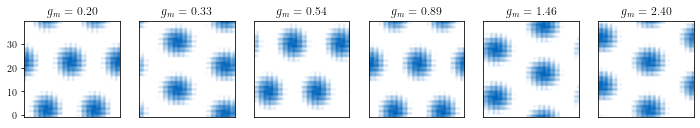

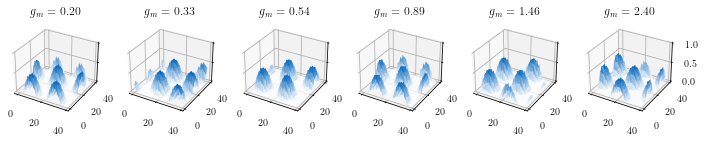

In [40]:
mpl.rcParams['animation.ffmpeg_path'] = "ffmpeg/ffmpeg"

# set time-step size of simulation
dt = 1e-2  # in seconds, use 1e-2 for sufficient results

# initialize Grid Cell Model
M = 6  # 6 for default, number of modules
n = 40  # 40 for default, size of sheet -> nr of neurons is squared
gmin = 0.2  # 0.2 for default, maximum arena size, 0.5 -> ~10m | 0.05 -> ~105m
gmax = 2.4  # 2.4 for default, determines resolution, don't pick to high (>2.4 at speed = 0.5m/s)
# note that if gc modules are created from data n and M are overwritten
gc_network = GridCellNetwork(n, M, dt, gmin, gmax=gmax, from_data=False)

nr_steps = 8000  # 8000 for decoder test, 15000 for maze exploration, 8000 for maze navigation
nr_steps_exploration = 3500  # 3500 for decoder test, nr_steps for maze exploration, 0 for maze navigation

nr_plots = 5  # allows to plot during the run of a simulation
nr_trials = 1  # 1 for default, 50 for decoder test, 1 for maze exploration

# Configure video if you want to export one
video = False  # False for default, set to True if you want to create a video of the run
fps = 5  # number of frames per s
step = int((1 / fps) / dt)  # after how many simulation steps a new frame is saved


In [41]:
s0 = gc_network.gc_modules[0].s

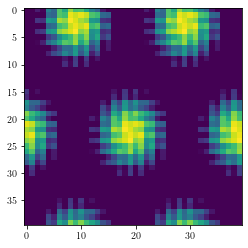

In [42]:
#print(s0.shape)
p = np.reshape(s0, (40,40))
plt.imshow(p)

In [79]:
import numpy as np
#from plotting.plotResults import plot_sub_goal_localization_pod


# Phase Offset Detectors based on Edvardsen 2015. For details on the implementation refer to the thesis or paper.
# Used for comparison of different decoders
# Code elements here follow a similar logic like the grid cell model.


def in_d(d):
    eta = 0.25
    lam = 15
    beta = 3 / (lam ** 2)
    # beta = 5 / (lam ** 2)

    weight = eta * (np.exp(-beta * (d ** 2)) - 1)
    return weight


def ex_d(d):
    lam = 15
    beta = 3 / (lam ** 2)
    # beta = 5 / (lam ** 2)

    weight = np.exp(-beta * (d ** 2))
    return weight


def compute_dspod(x_pod, x_grid):
    #print("x_pod_shape",x_pod.shape,"x_grid.shape", x_grid.shape)
    n = int(np.sqrt(len(x_grid)))

    x1 = np.transpose( np.tile(x_pod, (n ** 2, 1)))
    x2 = np.tile(x_grid, (len(x_pod), 1))
    #print("x_pod_shape",x1.shape ,"x_grid.shape", x2.shape)
    dx1 = np.abs(x2 - x1)
    dx2 = n - dx1
    dx = np.min([dx1, dx2], axis=0)
    return dx


class PhaseOffsetDetectorNetwork:
    def __init__(self, n_theta, n_xy, n):
        self.n_theta = n_theta
        self.n_xy = n_xy
        self.n = n

        self.w_ex_dict = {}

        delta = 7

        angles = np.linspace(0, 2 * np.pi, num=n_theta, endpoint=False)

        grid_pod = np.indices((n_xy, n_xy))
        x_pod = np.concatenate(grid_pod[1]) * int(n / n_xy)
        y_pod = np.concatenate(grid_pod[0]) * int(n / n_xy)

        grid = np.indices((n, n))
        x = np.concatenate(grid[1])
        y = np.concatenate(grid[0])

        dx = compute_dspod(x_pod, x)
        dy = compute_dspod(y_pod, y)
        d = np.linalg.norm([dx, dy], axis=0)

        self.w_in = in_d(d)

        self.factor = 0.2

        for idx, angle in enumerate(angles):
            grid_pod = np.indices((n_xy, n_xy))
            x_pod = np.concatenate(grid_pod[1]) * int(n / n_xy) + delta * np.cos(angle) * np.ones_like(x_pod)
            y_pod = np.concatenate(grid_pod[0]) * int(n / n_xy) + delta * np.sin(angle) * np.ones_like(y_pod)

            dx = compute_dspod(x_pod, x)
            dy = compute_dspod(y_pod, y)
            d = np.linalg.norm([dx, dy], axis=0)

            self.w_ex_dict[angle] = ex_d(d)

    def calculate_p(self, s, t):
        p_array = np.empty((self.n_theta, 1))
        print(t.shape, self.w_ex_dict[0].shape)
        for idx, angle in enumerate(self.w_ex_dict):
            p_in = np.multiply(np.tile(s, (int(self.n_xy ** 2), 1)), self.w_in)
            p_ex = np.multiply(np.tile(t, (int(self.n_xy ** 2), 1)), self.w_ex_dict[angle])

            p = np.maximum(0, np.sum(p_in, axis=1) + np.sum(p_ex, axis=1))
            print(p.shape)
            p_m = np.sum(p)
            p_array[idx] = p_m
            print(p_array.shape)
            if idx %6 == 0:
                plt.imshow(np.reshape(p_array, (1,1)))
        return p_array

    def compute_goal_vector(self, gc_modules, virtual=False):
        p_array = np.zeros((self.n_theta, 1))
        for gc in gc_modules:
            t = gc.t if not virtual else gc.s_virtual
            p_array_temp = self.calculate_p(gc.s, t) / gc.gm
            p_array = p_array + p_array_temp

        angles = list(self.w_ex_dict.keys())
        x = np.dot(np.cos(angles), p_array)[0]
        y = np.dot(np.sin(angles), p_array)[0]
        goal_vector = np.array([x, y]) * self.factor

        return goal_vector

    def compute_sub_goal_vector(self, gc_network, pc_network, cognitive_map, env, blocked_directions):

        sub_goal_dict = {}

        for idx, pc in enumerate(pc_network.place_cells):
            for m, gc in enumerate(gc_network.gc_modules):
                gc.s_virtual = pc.gc_connections[m]
            goal_vector = self.compute_goal_vector(gc_network.gc_modules, virtual=True)

            angle = np.arctan2(goal_vector[1], goal_vector[0])
            blocked = False
            for blocked_direction in blocked_directions:
                alternative_notation = blocked_direction - 2 * np.pi
                if abs(angle - blocked_direction) < np.pi / 7 or abs(angle - alternative_notation) < np.pi / 7:
                    blocked = True

            reward = cognitive_map.reward_cells[idx] if not blocked else -1
            sub_goal_dict[idx] = {"goal_vector": goal_vector, "blocked": blocked, "reward": reward}

        idx_pc = np.argmax([idx["reward"] for idx in sub_goal_dict.values()])
        sub_goal_vector = sub_goal_dict[idx_pc]["goal_vector"]
        # print("New Sub goal vector: ", sub_goal_vector, sub_goal_dict)
        plot_sub_goal_localization_pod(env, cognitive_map, pc_network, sub_goal_dict,
                                       env.goal_vector, idx_pc)

        return sub_goal_vector


In [80]:
POD = PhaseOffsetDetectorNetwork(16, 10, 40)

In [81]:
print(p.shape)

(40, 40)


In [85]:
V= np.array([1.5, 1.5])*0.2
nr_steps_shift =100
tau = 1e-1
dt = 1e-2
fig = plt.figure()
for i in range(nr_steps_shift):
    #B = calculate_B(V)
    B = 1 + 1.2 * 0.10315 * np.tensordot(gc_network.gc_modules[0].h, V, axes=1) 
    #s = implicit_euler(B, gc_network.gc_modules[0].s, gc_network.gc_modules[0].w, tau, dt)
    gc_network.gc_modules[0].update_s(V)
#print(t.shape)
t= s

#plt.imshow(np.reshape(s, (40,40)))

p = POD.compute_goal_vector(gc_network.gc_modules)
print(p.shape)
print(4)

(1600,) (100, 1600)
(100,)
(16, 1)


ValueError: cannot reshape array of size 16 into shape (1,1)

<Figure size 432x288 with 0 Axes>